Copyright 2022 Google LLC.

SPDX-License-Identifier: Apache-2.0

# Simple Diffusion

This colab is a demonstration of the code and principles behind the [Variational Diffusion Models paper](https://arxiv.org/abs/2107.00630) and serves as a standalone implementation to complement the [open source release](https://github.com/google-research/vdm).

The goal will be to have a minimalistic, easy to understand implementation of a diffusion model, most closely following the [VDM Paper](https://arxiv.org/abs/2107.00630)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/vdm/blob/main/colab/SimpleDiffusionColab.ipynb)


## Preamble

In [1]:
#@title imports

import jax
import jax.numpy as np
from jax import random, vmap, grad, jit
import numpy as onp
import matplotlib.pyplot as plt
import flax
import flax.linen as nn
import optax
import einops
from tqdm import tqdm, trange
import tensorflow_probability.substrates.jax as tfp
from scipy.stats import describe
import functools
from functools import partial
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
#tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds
tfd = tfp.distributions
tfb = tfp.bijectors
from clu import deterministic_data

2024-06-14 11:26:34.722170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/perl-5.34.1-4ryb2w6tlh6ha54x25kkpq7l5zjq56do/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/pcre2-10.36-viek2bpe7b5ktcr3qpyl2qhipy2ybjxs/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/zlib-1.2.11-wjg3emtnlrvv3sgzf4bief7g7m64sums/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/curl-7.83.0-yzcvzf3nqftyqhrki2zketnom3lbg3kf/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/openssl-1.1.1o-m6uvz6ittrnhnwd3oftfljxqwkve44j7/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/libidn2-2.3.0-qmmoo5lcgqh4crq2cbbwqe26b6ujugzx/lib:/gp

In [2]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image.

  Arguments:
    arr : array-like The image data. The shape can be one of MxN (luminance),
      MxNx3 (RGB) or MxNx4 (RGBA).
    vmin : scalar, optional lower value.
    vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
      image by fixing the values that map to the colormap color limits. If
      either *vmin* or *vmax* is None, that limit is determined from the *arr*
      min/max value.
    cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
      registered colormap name. The colormap maps scalar data to colors. It is
      ignored for RGB(A) data.
        Defaults to :rc:`image.cmap` ('viridis').
    origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
      of the array is in the upper
        left or lower left corner of the axes.  Defaults to :rc:`image.origin`
          ('upper').

  Returns:
    A uint8 image array.
  """
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = io.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    array: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = array.shape
  assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(math.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  array = array[:cut]
  array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
  array = np.moveaxis(array, axis + 2, axis + 1)
  array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
  return array

def zoom(im, k, axes=(0, 1)):
  for ax in axes:
    im = np.repeat(im, k, ax)
  return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
  if normalize:
    im = im - im.min()
    im = im / im.max()
  return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

def param_count(pytree):
  return sum(x.size for x in jax.tree_leaves(pytree))

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [3]:
import jax
print("devices:", jax.devices())
!nvidia-smi

devices: [CpuDevice(id=0)]
/bin/bash: nvidia-smi: command not found


/gpfs/space/home/rooben/.conda/envs/vldm/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Data

For this example colab, we'll be using the [EMNIST dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of handwritten numbers and letters.  Think of EMNIST as a larger drop-in replacement for MNIST.

To keep things simple, we will model binarized data.  To binarize the data we will treat the continuous values stored in the dataset as probabilities for independently sampling the pixels in the image.

In [4]:
train_acts = np.load("./resnet18_open_cif100_coarse_tr.npy")
ood_acts = np.load("./resnet18_open_cif100_coarse_ood.npy")
test_acts = np.load("./resnet18_open_cif100_coarse_te.npy")
y_train = np.load("./cif100_train_y.npy")
y_test = np.load("./cif100_test_y.npy")


In [8]:
data_mean_cl_wise = np.array([np.mean(train_acts[y_train== i],0) for i in range(100)])
data_std_cl_wise = np.array([np.std(train_acts[y_train == i],0) for i in range(100)])

In [103]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_acts, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_acts, y_test))
ood_dataset = tf.data.Dataset.from_tensor_slices((ood_acts, np.zeros(len(ood_acts))))


# Batch the datasets
batch_size = batch_size = 128 // jax.device_count()
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).repeat()
test_dataset = test_dataset.batch(batch_size)
ood_dataset = ood_dataset.batch(batch_size)

def create_input_iter(ds):
    def _prepare(xs):
        def _f(x):
            return np.array(x)
        return jax.tree_util.tree_map(_f, xs)
    it = iter(ds)  # Create an iterator
    for batch in it:
        yield _prepare(batch)  # Yield prepared batch

train_iter = create_input_iter(train_dataset)
test_iter = create_input_iter(test_dataset)
ood_iter = create_input_iter(ood_dataset)
# Example usage: Getting the first batch
out = next(train_iter)
print(out[0].shape, out[1].shape)

(128, 512) (128,)


## Background

There are some [great](https://yang-song.net/blog/2021/score/) [introductions](https://huggingface.co/blog/annotated-diffusion) to diffusion and score-based models. Here we're going to focus on the interpretation of these models in [Variational Diffusion Models (VDM)](https://arxiv.org/abs/2107.00630) where diffusion models are thought of as a hierarchical latent variable model like a [Variational Autoencoder (VAE)](https://arxiv.org/abs/1312.6114).

The KL divergence is non-negative, which means that the KL between two joint distributions upper bounds the KL of their marginals:
$$ \int dx\, dz\, p(x,z) \log \frac{p(x,z)}{q(x,z)} = \int dx\, p(x) \log \frac{p(x)}{q(x)} + \left[ \int dx\, p(x) \int dz\, p(z|x) \log \frac{p(z|x)}{q(z|x)}\right] \\ \geq \int dx\, p(x) \log \frac{p(x)}{q(x)} \geq 0 $$
This immediately let's us generate an upper bound on the marginal likelihood of one joint in terms of another.  This can motivate the use of ELBO for training VAEs.

Naturally, this trick works even if we add more variables.  Imagine extending our forward process so that it has $T$ total steps, $x \to z_0 \to z_1 \to z_2 \to \cdots \to z_T$.  By monotonicity, the KL between the full joints will still be an upper bound on the KL between the marginals.

$$ \int dx\, \prod_i dz_i\, q(x,z_0,\cdots,z_T) \log \frac{q(x) q(z_0|x) q(z_1|z_0) \cdots q(z_T|z_{T-1})}{p(x|z_0) p(z_0|z_1)\cdots p(z_{T-1}|z_T) p(z_T)}   \geq \int dx\, q(x) \log \frac{q(x)}{p(x)} \geq 0 $$

If we add enough steps and try to ensure that the conditional KLs are small enough, we might hope to get a very good generative model...

## Forward process

We'll choose as our forward process a simple Gaussian diffusion process, that adds increasing amounts of noise at each step.

That is we'll take:
$$ q(z_t|z_{t-1} ) = \mathcal N(\alpha_{t|t-1} z_{t-1} , \sigma^2_{t|t-1} I ) $$
Where we'll take the previous sample and scale it down and add some gaussian noise to it.  Here and in a lot of the diffusion work, the process is taken to be *variance preserving* by setting:
$$ \alpha^2 = 1 - \sigma^2 $$

One particuarly nice thing about using gaussians for every step of the forward process here is that the composition of a bunch of conditional gaussians is itself gaussian so we will have a closed form for the marginal distribution at any intermediate time:
$$ q(z_t|x) = \mathcal N(\alpha_t x, \sigma_t^2 I )$$
which will itself be variance preserving:
$$ \alpha_t = \sqrt{1 - \sigma_t^2} .$$

At this point, the entire forward process is characterized by the amount of noise we've added at each stage.  Another way we could discuss this is in terms of the *signal-to-noise* ratio,
$$ \mathsf{snr}_t = \frac{\alpha_t^2}{\sigma^2_t} $$

There are lots of ways to describe the same thing, but the point is that as long as we are content to restrict our attention to variance preserving gaussian forward processes, then the entire process is characterized by a single curve, a noise schedule that determines how much noise we add at each step.  In a lot of diffusion work this schedule is fixed, but in the VDM paper it is learned by means of a neural network.  To obtain an efficient parameterization of the process, we'll parameterize the noise schedule in terms of the log signal to noise ratio.

$$ \gamma(t) = \log \mathsf{snr}_t = \log \frac{\alpha_t^2}{\sigma_t^2} $$

So we can see for instance that:
$$ \sigma_t^2 = \textsf{sigmoid}(-\gamma(t) ) $$
(Note that this has a sign flip with respect to the VDM paper, where $\gamma$ was the negative of the log SNR).

$\gamma(t)$ could in general be a learned neural network, but to keep things simple, in this colab we'll fix
$$\gamma(t) = \gamma_{\min} + (\gamma_{\max} - \gamma_{\min}) t $$
for a value of $t$ that ranges from 0 to 1, so that our log snr is linear in $t$ and all we have to choose is the mininimum and maximum log snr value.


In [20]:
def gamma(ts, gamma_min=-6, gamma_max=6):
  return gamma_max + (gamma_min - gamma_max) * ts

def sigma2(gamma):
  return jax.nn.sigmoid(-gamma)

def alpha(gamma):
  return np.sqrt(1 - sigma2(gamma))

For a schedule which has linear log snr, the $\alpha$ and $\sigma^2$ values look like sigmoids:

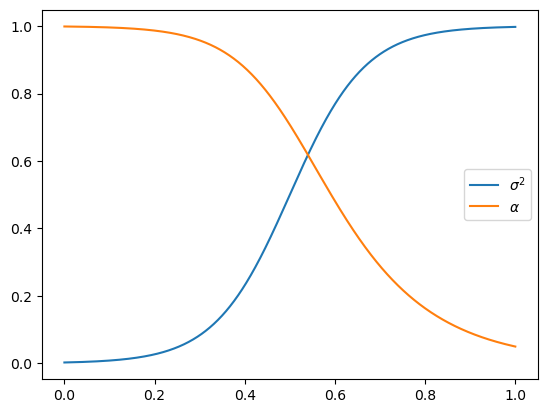

In [21]:
ts = np.linspace(0, 1, 1000)
plt.plot(ts, sigma2(gamma(ts)), label=r'$\sigma^2$')
plt.plot(ts, alpha(gamma(ts)), label=r'$\alpha$')
plt.legend();

We can visualize what this would look like for a batch of images:

In [22]:
def variance_preserving_map(x, gamma, eps):
  a = alpha(gamma)
  var = sigma2(gamma)
  return a * x + np.sqrt(var) * eps

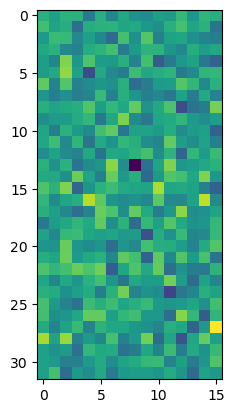

In [38]:
plt.imshow(results[0][-1])

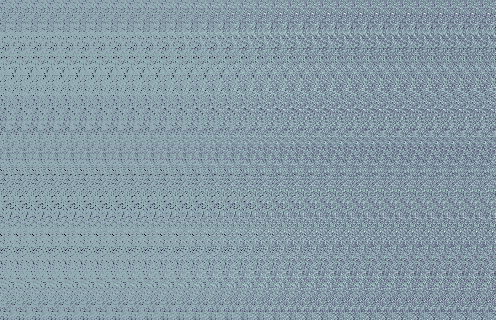

In [31]:

ii = (2 * out[0][:10].squeeze() - 1).reshape(10,32,16)
ii.shape
TT = 30
results = np.zeros((10, TT+1, 32, 16))
results = results.at[:,0].set(ii)

tt = np.linspace(0, 1, TT)
eps = random.normal(jax.random.PRNGKey(0), (10, 32, 16))
for i, t in enumerate(tt):
  results = results.at[:,i+1].set(variance_preserving_map(ii, gamma(t), eps))
rawarrview(reshape_image_batch(results.reshape((-1, 32, 16)), rows=10), cmap='bone_r')

Many diffusion models perform this forward process in pixel space, but to make this colab more efficient and cheaper to train we are going to use *latent diffusion*, in that our first step $q(z_0|x)$ is going to use an encoder much like an ordinary gaussian VAE model that maps the image to some lower dimensional latent representation, and we'll then be adding gaussian noise in this latent space.  In particular if the first step gaussian is set to have a nonlinear mean:

$$ q(z_0|x) = \mathcal N ( f(x), \sigma_0^2 I ) $$
Then we'll still be able to compute some later step in the forward process $q(z_t|x)$ in closed form.

## Reverse Process

With the forward process in place, now we tackle the reverse (and our learned model).

We can do a bit of math there. We've defined a whole set of encoding distribuitons of the form:

$$ q(z_t | x) = \mathcal N (\alpha_t x, \sigma_t^2 I) $$

which means we can work out various conditionals, first notice that since everything is Gaussian

$$ q(z_t | z_s) =\mathcal N (\alpha_{t|s} x, \sigma_{t|s}^2 I) $$
with
$$\alpha_{t|s} = \frac{\alpha_t}{\alpha_s} $$
$$ \sigma_{t|s}^2 = \sigma_{t}^2 - \alpha_{t|s}^2 \sigma_s^2 $$
<!-- not sure the easiest way to show these results but they make sense.  
I guess we could just reason in terms of moments.  If we have $z_s$ then to get $z_t$ we want to multiply by $\alpha_{t|s}$ and since variances add, we can also get the variances to line up. -->

So the next question becomes, what does the $q(z_s|z_t,x)$ distribution look like?

We have that:

$$ q(z_s|z_t,x) = \frac{q(z_t|z_s,x) q(z_s|x)}{q(z_t|x)} = \frac{q(z_t|z_s)q(z_s|s)}{q(z_t|x)} = \mathcal N(\mu_Q(z_t, x, s, t), \sigma_Q^2(s, t) I) $$
where (which you can get from matching moments

$$ \mu_Q(z_t, x, s, t) = \frac{\alpha_{t|s} \sigma_s^2}{\sigma_t^2} z_t + \frac{\alpha_s \sigma_{t|s}^2}{\sigma_t^2} x $$
and
$$ \sigma_Q^2(s,t) = \sigma_{t|s}^2 \sigma_s^2 / \sigma_t^2 $$

So, in words, in our original forward process, the conditional reverse process, that is the probability of getting some $z_s$ at an earlier stage if we know both a later stage $z_t$ as well as the original image is a conditional gaussian, a sort of mixing of $z_t$ and $x$.

So, in the diffusion model, we try to match things and so we choose as our reverse process something of the form:

$$ p(z_t|z_s) = q(z_s | z_t, x = \hat x_\theta(z_t;t)) $$
this seems to be the crucial thing we have going on here.  We are making a structural assumption about the form of the reverse process.  In the limit of infinite number of steps, this reverse process would be exact. We are going to learn the reverse process, but we are going to make use of a large amount of knowledge we have about the forward process to parameterize it intelligently.  Here we are going to learn the reverse process so that it has the form of the conditional reverse of the forward process. Writing things out, this means the mean takes the form:

$$ \begin{align}
  \mu_\theta(z_t; s, t) &= \frac{\alpha_{t|s}\sigma_s^2}{\sigma_t^2} z_t + \frac{\alpha_s \sigma_{t|s}^2}{\sigma_t^2} \hat x_\theta(z_t; t) \\
  &= \frac{1}{\alpha_{t|s}} z_t - \frac{\sigma_{t|s}^2}{\alpha_{t|s}\sigma_t} \hat \epsilon_\theta(z_t;t) \\
  &= \frac{1}{\alpha_{t|s}} z_t + \frac{\sigma_{t|s}^2}{\alpha_{t|s}} s_\theta(z_t;t)
\end{align} $$

This shows that we can think about this thing and parameterize it in terms of three different things, either the denoised image $\hat x$, or the noise $\hat \epsilon$ or the scores.  The relationship between the denoised image and the noise itself is:

$$  \hat x_\theta(z_t, t) = (z_t - \sigma_t \hat \epsilon_\theta(z_t; t) ) / \alpha_t $$

This is the actual learned component of our model here.  We are attempting to learn a model that at any intermediate stage of corruption allows us to predict what the uncorrupted image was.  We can either do that directly $\hat x_\theta$, or equivalent to saying what the uncorrupted image is, we can spit out the corruption as in $\hat \epsilon_\theta$.  Finally, as is shown in the VDM paper in appendix L, we could also connect back to the denoising diffusion type models and think about the task as learning the score model $s_\theta$ for the marginal of the forward process:
$$ s_\theta(z_t) = \nabla_{z_t} \log q(z_t)  $$

To actually learn this model, we need to build out the parametric model architecture. In the VDM paper they use a type of U-Net.  We need to take in a perturbed image and try to predict the noise that is in that image.  This means we have an image sized input and want to produce an image sized output.  Another important part is that we want to have the thing conditioned on the time step we are on so we can use the same architecture for the whole of the process.

## Loss

With most of our pieces in place, now we need to stick them all together and look at the form of our loss.

At a high level, our loss is quite simple in form, we have a forward and a reverse process and our loss is simply the KL divergence of the forward to the reverse process:

$$ \mathcal J = \left\langle \log \frac{q(x, z_0,z_1,\cdots,z_T)}{p(x, z_0,z_1,\cdots,z_T)} \right\rangle_q \geq \left\langle \log \frac{q(x)}{p(x)} \right\rangle_q \geq 0 $$
$q$ is our forward process which starts with an image and does successive steps of gaussian diffusion to it.  The reverse process starts from an isotropic gaussian and then runs our reverse process.  KL divergence is non-negative, and its also *monotonic* in the sense that any transformation of the random variables will reduce the KL between two distributions.  One form of transformation we could do is marginalization.  So we know that if we look at the KL of the $N$ step forward and reverse processes, that will be an upper bound on the KL divergence between the marginal $x$ distributions, $q(x)$ being the image distribution we start our forward samples from (the thing we're trying to learn to approximate) and $p(x)$ the marginal of running our reverse process.  So without any real work, we're assured that by minimizing the KLs between the full joints of the forward and reverse process the reverse process itself is going to learn to approximate the true image distribution.



To get this into a recognizeable and computable form, we're going to do the kind of rearrangement we considered above, so, while its most natural and we discussed the forward process as being a sequence of steps:

$$ q(x,z_0,z_1,z_2,\cdots,z_T) = q(x) q(z_0|x) q(z_1|z_0) q(z_2|z_1) \cdots q(z_T|z_{T-1}) $$
we can just as well imagine a different factorization that leaves the conditioning on the first step explicit:
$$
\begin{align}
q(x, z_0, z_1, z_2,\cdots, z_N) &= q(z_0,z_1,z_2,\cdots, z_T|x) q(x) \\
&= q(z_0|z_1,\cdots,z_T,x)q(z_1|z_2,\cdots,z_T,x)q(z_T|x)q(x) \\
&= q(z_0|z_1,x)q(z_1|z_2,x)\cdots q(z_{T-1}|z_{T},x)q(z_T|x)p(x)
\end{align}$$

In the other direction we consider the natural factorization of the reverse process:
$$ p(x,z_0,z_1,\cdots,z_T) = p(z_T) p(z_{T-1}|z_T) \cdots p(z_0|z_1) p(x|z_0) $$

With these factorizations in place we can now look at the full KLs and organize terms.

$$
  \left\langle \log q(x) - \log p(x|z_0) + \log \frac{q(z_T|x)}{p(z_T)}  
  + \sum_{i=0}^{T-1} \log \frac{q(z_i|z_{i+1},x)}{p(z_i|z_{i+1})}
  \right\rangle_q
$$

The last trick we're going to use is that we're going to avoid computing all of the terms in our sum by simply not computing all of the terms in our sum.  We'll approximate the sum with monte carlo, we'll simply randomly choose one of the terms and upweight it by the number of terms in the sum.

## Architecture

Now we are ready to build out the architecture for our model.  First we want to be able to embed our timestep to a higher dimensional signal that the model can use to do some interesting conditioning.  For that we'll use some fourier feature inspired embeddings.

In [39]:
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
  """Build sinusoidal embeddings (from Fairseq)."""

  assert len(timesteps.shape) == 1
  timesteps *= 1000

  half_dim = embedding_dim // 2
  emb = np.log(10_000) / (half_dim - 1)
  emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
  emb = timesteps.astype(dtype)[:, None] * emb[None, :]
  emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
  if embedding_dim %2 == 1: # zero pad
    emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
  assert emb.shape == (timesteps.shape[0], embedding_dim)
  return emb

Next as a sort of primitive, for this work we'll be using a simple resnet style architecture for the components.

In [40]:
class ResNet(nn.Module):
  hidden_size: int = 512
  n_layers: int = 1
  middle_size: int = 1024

  @nn.compact
  def __call__(self, x, cond=None):
    assert x.shape[-1] == self.hidden_size, "Input must be hidden size."
    z = x
    for i in range(self.n_layers):
      h = nn.gelu(nn.LayerNorm()(z))
      h = nn.Dense(self.middle_size)(h)
      if cond is not None:
        h += nn.Dense(self.middle_size, use_bias=False)(cond)
      h = nn.gelu(nn.LayerNorm()(h))
      h = nn.Dense(self.hidden_size, kernel_init=jax.nn.initializers.zeros)(h)
      z = z + h
    return z



Since we are doing latent diffusion here, we need an initial encoder to map our images to some lower dimensional space, here we use a resnet to accomplish this.

And then at the end of our chain, we need a decoder to map the latent representation to a full sized image again.  For this we'll use another small resnet and use a mean field bernoulli observiational model.  While this normally might be a poor approximation, in this colab we are doing dynamic binarization of the emnist digits, so this is a good model for the final observed noise in the data.

Finally, the real meat and potatoes of our diffusion model is the scorenet, a model that given a noisy image tries to predict the noise that is contained in that image.  It tries to clean up the image but by prediciting what you should remove.

This architecture needs to map a latent sized object to another latent sized object, so we'll use another resnet, but be sure to feed in our conditioning signal in a FiLM style.

In [41]:
class ScoreNet(nn.Module):
  embedding_dim: int = 512
  n_layers: int = 10

  @nn.compact
  def __call__(self, z, g_t, conditioning):
    n_embd = self.embedding_dim

    t = g_t
    assert np.isscalar(t) or len(t.shape) == 0 or len(t.shape) == 1
    t = t * np.ones(z.shape[0])  # ensure t is a vector

    temb = get_timestep_embedding(t, n_embd)
    cond = np.concatenate([temb, conditioning], axis=1)
    cond = nn.swish(nn.Dense(features=n_embd * 4, name='dense0')(cond))
    cond = nn.swish(nn.Dense(features=n_embd * 4, name='dense1')(cond))
    cond = nn.Dense(n_embd)(cond)

    h = nn.Dense(n_embd)(z)
    h = ResNet(n_embd, self.n_layers)(h, cond)
    return z + h


With the components in place we can build our our actual VDM model.  The main callable here computes an unbiased estimate of our VDM loss.

In [42]:

class VDM(nn.Module):
  timesteps: int = 1000
  gamma_min: float = -3.0 # -13.3
  gamma_max: float = 3.0  # 5.0
  embedding_dim: int = 512
  antithetic_time_sampling: bool = True
  layers: int = 32
  classes: int = 101

  def setup(self):
    self.gamma = partial(gamma, gamma_min=self.gamma_min, gamma_max=self.gamma_max)
    self.score_model = ScoreNet(n_layers=self.layers,
                                embedding_dim=self.embedding_dim)

    self.embedding_vectors = nn.Embed(self.classes, self.embedding_dim)

  def gammat(self, t):
    return self.gamma(t)

  def recon_loss(self, x, f, cond):
    """The reconstruction loss measures the gap in the first step.

    We measure the gap from encoding the image to z_0 and back again."""
    # ## Reconsturction loss 2
    g_0 = self.gamma(0.0)
    eps_0 = random.normal(self.make_rng("sample"), shape=f.shape)
    z_0 = variance_preserving_map(f, g_0, eps_0)
    z_0_rescaled = z_0 / alpha(g_0)
    loss_recon = -self.decoder(z_0_rescaled, cond).log_prob(x.astype('int32'))
    return loss_recon

  def latent_loss(self, f):
    """The latent loss measures the gap in the last step, this is the KL
    divergence between the final sample from the forward process and starting
    distribution for the reverse process, here taken to be a N(0,1)."""
    # KL z1 with N(0,1) prior
    g_1 = self.gamma(1.0)
    var_1 = sigma2(g_1)
    mean1_sqr = (1. - var_1) * np.square(f)
    loss_klz = 0.5 * np.sum(mean1_sqr + var_1 - np.log(var_1) - 1., axis=-1)
    return loss_klz

  def diffusion_loss(self, t, f, cond):
    # sample z_t
    g_t = self.gamma(t)
    eps = jax.random.normal(self.make_rng("sample"), shape=f.shape)
    z_t = variance_preserving_map(f, g_t[:, None], eps)
    # compute predicted noise
    eps_hat = self.score_model(z_t, g_t, cond)
    # compute MSE of predicted noise
    loss_diff_mse = np.sum(np.square(eps - eps_hat), axis=-1)

    # loss for finite depth T, i.e. discrete time
    T = self.timesteps
    s = t - (1./T)
    g_s = self.gamma(s)
    loss_diff = .5 * T * np.expm1(g_s - g_t) * loss_diff_mse
    return loss_diff

  def __call__(self, images, conditioning,
               sample_shape=()):
    x = images
    n_batch = images.shape[0]
    print(n_batch)
    cond = self.embedding_vectors(conditioning)
#1. impemnt the rec loss as a rec loss between the z the the denoised z_0

    # 2. LATENT LOSS
    # KL z1 with N(0,1) prior
    loss_klz = self.latent_loss(x)

    # 3. DIFFUSION LOSS
    # sample time steps
    rng1 = self.make_rng("sample")
    if self.antithetic_time_sampling:
      t0 = jax.random.uniform(rng1)
      t = np.mod(t0 + np.arange(0., 1., step=1. / n_batch), 1.0)
    else:
      t = jax.random.uniform(rng1, shape=(n_batch,))

    # discretize time steps if we're working with discrete time
    T = self.timesteps
    t = np.ceil(t * T) / T

    loss_diff = self.diffusion_loss(t, x, cond)

    # End of diffusion loss computation
    return (loss_diff, loss_klz)

  def embed(self, conditioning):
    return self.embedding_vectors(conditioning)

  def sample_step(self, rng, i, T, z_t, conditioning, guidance_weight=0.):
    rng_body = jax.random.fold_in(rng, i)
    eps = random.normal(rng_body, z_t.shape)
    t = (T - i)/T
    s = (T - i - 1) / T

    g_s = self.gamma(s)
    g_t = self.gamma(t)

    cond = self.embedding_vectors(conditioning)

    eps_hat_cond = self.score_model(
        z_t,
        g_t * np.ones((z_t.shape[0],), z_t.dtype),
        cond,)

    eps_hat_uncond = self.score_model(
        z_t,
        g_t * np.ones((z_t.shape[0],), z_t.dtype),
        cond * 0.,)
    eps_hat = (1. + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond


    a = nn.sigmoid(g_s)
    b = nn.sigmoid(g_t)
    c = -np.expm1(g_t - g_s)
    sigma_t = np.sqrt(sigma2(g_t))
    z_s = np.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1. - a) * c) * eps
    return z_s


  def recon(self, z, t, conditioning):
    g_t = self.gamma(t)[:, None]
    cond = self.embedding_vectors(conditioning)
    eps_hat = self.score_model(z, g_t, cond)
    sigmat = np.sqrt(sigma2(g_t))
    alphat = np.sqrt(1 - sigmat**2)
    xhat = (z - sigmat * eps_hat ) / alphat
    return (eps_hat, xhat)


With the model defined, we'll define a few helper functions to let us do generations, reconstructions or likelihood calculations with our model.

In [90]:
def generate(vdm, params, rng, shape, conditioning, guidance_weight=0.0):
  # first generate latent
  rng, spl = random.split(rng)
  zt = random.normal(spl, shape + (vdm.embedding_dim,))

  def body_fn(i, z_t):
    return vdm.apply(
        params,
        rng,
        i,
        vdm.timesteps,
        z_t,
        conditioning,
        guidance_weight=guidance_weight,
        method=vdm.sample_step)

  z0 = jax.lax.fori_loop(
      lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)
  g0 = vdm.apply(params, 0.0, method=vdm.gammat)
  var0 = sigma2(g0)
  z0_rescaled = z0 / np.sqrt(1. - var0)
  return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)


def recon(vdm, params, rng, t, ims, conditioning):
  # first generate latent
  rng, spl = random.split(rng)
  z_0 = vdm.apply(params, ims, conditioning, method=vdm.encode)

  T = vdm.timesteps
  tn = np.ceil(t * T)
  t = tn / T
  g_t = vdm.apply(params, t, method=vdm.gammat)
  rng, spl = random.split(rng)
  eps = jax.random.normal(spl, shape=z_0.shape)
  z_t = variance_preserving_map(z_0, g_t[:,None], eps)

  def body_fn(i, z_t):
    return vdm.apply(
        params,
        rng,
        i,
        vdm.timesteps,
        z_t,
        conditioning,
        method=vdm.sample_step)

  z0 = jax.lax.fori_loop(
      lower=(T - tn).astype('int'),
      upper=vdm.timesteps, body_fun=body_fn, init_val=z_t)
  g0 = vdm.apply(params, 0.0, method=vdm.gammat)
  var0 = sigma2(g0)
  z0_rescaled = z0 / np.sqrt(1. - var0)
  return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)



In [91]:
def elbo(vdm, params, rng, ims, conditioning):
  x = ims
  rng, spl = jax.random.split(rng)
  cond = vdm.apply(params, conditioning, method=vdm.embed)
  f = vdm.apply(params, ims, conditioning, method=vdm.encode)
  loss_recon = vdm.apply(params, x, f, cond, rngs={"sample": rng}, method=vdm.recon_loss)
  loss_klz = vdm.apply(params, f, method=vdm.latent_loss)

  def body_fun(i, val):
    loss, rng = val
    rng, spl = jax.random.split(rng)
    new_loss = vdm.apply(params, np.array([i / vdm.timesteps]), f, cond, rngs={"sample": spl}, method=vdm.diffusion_loss)
    return (loss + new_loss / vdm.timesteps, rng)

  loss_diff, rng = jax.lax.fori_loop(
      0, vdm.timesteps, body_fun, (np.zeros(ims.shape[0]), rng))

  return loss_recon + loss_klz + loss_diff

## Training

With all the components in place, its time to train our model

In [43]:
vdm = VDM(gamma_min=-5.0,
          gamma_max=1.0,
          layers=4,
          embedding_dim=512,
          timesteps=1000)
rng = random.PRNGKey(0)

batch = next(create_input_iter(train_dataset))[0]
conditioning = np.zeros(128, dtype='int')
out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, conditioning)
print(f"Params: {param_count(params):,}")



2024-06-14 11:57:15.057158: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
/tmp/ipykernel_142137/2094555486.py:9: UserWarning: Explicitly requested dtype int requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  conditioning = np.zeros(128, dtype='int')


128
Params: 13,968,896


/tmp/ipykernel_142137/2488472922.py:108: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  return sum(x.size for x in jax.tree_leaves(pytree))


In [47]:
def loss(params, rng, im, lb, beta=1.0):
  l1, l2 = vdm.apply(params, im.astype('float'), lb, rngs={"sample": rng})
  rescale_to_bpd = 1./(onp.prod(im.shape[1:]) * np.log(2.0))
  return (l1.mean()/beta + l2.mean()/beta ) * rescale_to_bpd





In [44]:
from typing import Any

@flax.struct.dataclass
class Store:
  params: np.ndarray
  state: Any
  rng: Any
  step: int = 0


TSTEPS = 20_000 // jax.device_count()

# we'll use adamw with some linear warmup and a cosine decay.
opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, TSTEPS, 1e-5)),
    optax.adamw(8e-4, b1=0.9, b2=0.99, eps=1e-8, weight_decay=1e-4),
    optax.scale_by_schedule(
        optax.linear_schedule(0.0, 1.0, 250)))

store = Store(params, opt.init(params), rng, 0)
pstore = replicate(store)

We'll make a simple step function that we can pmap to make better use of our accelerators.

In [48]:
import functools

@functools.partial(jax.pmap, axis_name='batch')
def step(store, batch):
  rng, spl = random.split(store.rng)
  im, lb = batch
  out, grads = jax.value_and_grad(loss)(store.params, spl, im, lb)
  grads = jax.lax.pmean(grads, 'batch')
  updates, state = opt.update(grads, store.state, store.params)
  params = optax.apply_updates(store.params, updates)

  return (store.replace(
      params=params,
      state=state,
      rng=rng,
      step=store.step + 1),
      jax.lax.pmean(out, 'batch'))


In [ ]:
@flax.struct.dataclass
class Store:
    params: Any
    state: Any
    rng: Any
    step: int = 0

TSTEPS = 1000

opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, TSTEPS, 1e-5)),
    optax.adamw(8e-4, b1=0.9, b2=0.99, eps=1e-8, weight_decay=1e-4),
    optax.scale_by_schedule(
        optax.linear_schedule(0.0, 1.0, 250))
)

store = Store(params=params, state=opt.init(params), rng=rng, step=0)

def step(store, batch):
    rng, spl = random.split(store.rng)
    latents, lb = batch
    out, grads = jax.value_and_grad(loss)(store.params, spl, latents, lb)
    updates, state = opt.update(grads, store.state, store.params)
    params = optax.apply_updates(store.params, updates)

    return store.replace(
        params=params,
        state=state,
        rng=rng,
        step=store.step + 1), out

vals = []

batches = create_input_iter(train_dataset)
ebatches = create_input_iter(test_dataset)

with trange(TSTEPS) as t:
    for i in t:
        store, val = step(store, next(batches))
        t.set_postfix(val=val)
        vals.append(val)





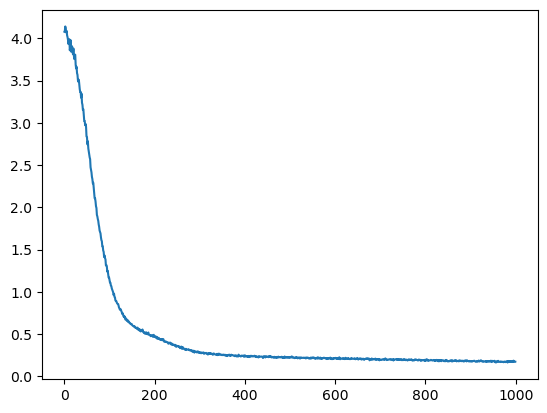

In [50]:
plt.plot(vals)

In [ ]:
def generate(vdm, params, rng, shape, conditioning, guidance_weight=0.0):
    rng, spl = random.split(rng)
    zt = random.normal(spl, shape + (vdm.embedding_dim,))

    def body_fn(i, z_t):
        return vdm.apply(
            params,
            rng,
            i,
            vdm.timesteps,
            z_t,
            conditioning,
            guidance_weight=guidance_weight,
            method=vdm.sample_step)

    z0 = jax.lax.fori_loop(
        lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)
    return z0

conditioning = np.arange(128) % 101  # Update the conditioning labels as needed
gen_latents = generate(vdm, store.params, rng, (128,), conditioning)

def elbo(vdm, params, rng, latents, conditioning):
    x = latents
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = latents

    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)

    def body_fun(i, val):
        loss, rng = val
        rng, spl = jax.random.split(rng)
        new_loss = vdm.apply(params, np.array([i / vdm.timesteps]), f, cond, rngs={"sample": spl}, method=vdm.diffusion_loss)
        return (loss + new_loss / vdm.timesteps, rng)

    loss_diff, rng = jax.lax.fori_loop(
        0, vdm.timesteps, body_fun, (np.zeros(latents.shape[0]), rng))

    return loss_klz + loss_diff




In [53]:
# Example usage: Evaluating the likelihood of the generated samples
conditioning = np.zeros(gen_latents.shape[0], dtype='int')
elbos = elbo(vdm, store.params, rng, gen_latents, conditioning)

# Print the ELBO values
print("ELBO for test samples:", elbos)

/tmp/ipykernel_142137/3074656779.py:2: UserWarning: Explicitly requested dtype int requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  conditioning = np.zeros(gen_latents.shape[0], dtype='int')


ELBO for test samples: [250.30365 295.5894  295.31128 305.167   305.09528 284.59082 316.25638
 310.40268 325.59967 324.75693 291.56625 317.74432 316.97217 319.77444
 316.37207 296.20096 271.8873  343.81378 321.3403  303.48825 329.4467
 299.8489  285.93158 289.14664 294.53598 301.1982  329.48984 330.6293
 330.09048 300.8248  328.80978 314.51025 270.84393 306.454   302.08365
 308.783   324.21646 304.1803  309.99774 299.28952 291.36633 309.8154
 321.86533 330.056   296.94687 295.3938  292.41754 321.83786 354.04312
 302.9985  320.3809  304.61893 307.24338 295.9537  301.08923 298.7213
 324.93738 278.94412 307.57748 287.34967 299.02133 294.1771  295.3309
 319.51743 314.8708  292.69122 319.3516  277.85278 323.90097 307.65845
 290.91418 315.11017 306.82797 290.0951  308.02032 312.49335 298.61264
 301.94156 297.61868 294.92523 298.85297 290.70197 333.1512  293.81573
 292.41333 299.37378 295.9972  308.42496 299.4623  268.30872 293.104
 291.64288 285.16376 300.16617 315.3685  294.14835 279.2557  

Our actual training, with the standard configuration in this colab, and using a GPU as an accelerator this should take about ~30 minutes on a T4.

our loss went down nicely over time.

## Loss

We can evaluate the loss of the model on the test set (here just a single batch but can be extended).

We can evaluate both the conditional likelihood:

In [167]:
batches = create_input_iter(train_dataset)
ebatches = create_input_iter(test_dataset)
obatches = create_input_iter(ood_dataset)

conditioning = np.arange(128) % 101

In [170]:
def get_losses(batches,runs):
    losses = []
    for i in range(runs):
        batch = next(batches)
        ims, lbs = batch
        loss_diff, loss_klz = vdm.apply(store.params, ims, 0*conditioning, rngs={"sample": rng})
        losses.append(loss_diff+loss_klz)
    return losses
        #losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff_tr, "loss_klz": loss_klz_tr})
        #print(losses, "\n", sum(losses.values()))

In [ ]:
loss_te = get_losses(ebatches,50)

In [176]:
loss_te = np.array(loss_te).flatten()

In [177]:
loss_ood = get_losses(obatches,50)

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [178]:
loss_ood = np.array(loss_ood).flatten()

In [144]:
batch = next(ebatches)
ims, lbs = batch
loss_diff_te, loss_klz_te = vdm.apply(store.params, ims, 0*conditioning, rngs={"sample": rng})
losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff_te, "loss_klz": loss_klz_te})
print(losses, "\n", sum(losses.values()))

128
{'loss_diff': Array(0.3815386, dtype=float32), 'loss_klz': Array(0.001344, dtype=float32)} 
 0.3828826


/tmp/ipykernel_142137/1520387202.py:4: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff_te, "loss_klz": loss_klz_te})


In [145]:
batch = next(obatches)
conditioning = np.arange(128) % 101
ims, lbs = batch
loss_diff_ood, loss_klz_ood = vdm.apply(store.params, ims, 0*conditioning, rngs={"sample": rng})
losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff_ood, "loss_klz": loss_klz_ood})
print(losses, "\n", sum(losses.values()))

128
{'loss_diff': Array(0.36393753, dtype=float32), 'loss_klz': Array(0.00108137, dtype=float32)} 
 0.3650189


/tmp/ipykernel_142137/2905348120.py:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff_ood, "loss_klz": loss_klz_ood})


In [146]:
loss_klz_tr

Array([0.37353253, 0.423456  , 0.65225977, 0.53539306, 0.46156764,
       0.4924701 , 0.5091184 , 0.24738938, 0.542389  , 0.47946912,
       0.6594127 , 0.37604243, 0.5306739 , 0.5045085 , 0.4125778 ,
       0.43664968, 0.41489673, 0.46964508, 0.6462734 , 0.5009708 ,
       0.34161258, 0.49619448, 0.4017042 , 0.41619378, 0.6458928 ,
       0.7742861 , 0.45367557, 0.6855296 , 0.46310413, 0.48392504,
       0.50151366, 0.48037857, 0.6095658 , 0.5181275 , 0.59725904,
       0.41547382, 0.48124588, 0.60661644, 0.41237122, 0.41295135,
       0.64258134, 0.57469344, 0.6937625 , 0.3477332 , 0.42459697,
       0.65472525, 0.49111617, 0.48136312, 0.40306348, 0.55797136,
       0.46073627, 0.39648974, 0.40967554, 0.4331156 , 0.5210539 ,
       0.5263808 , 0.5039432 , 0.47508943, 0.44169164, 0.5283728 ,
       0.450602  , 0.42290485, 0.41276002, 0.54730767, 0.39968717,
       0.50239426, 0.43461126, 0.55767995, 0.35265827, 0.4350819 ,
       0.4325937 , 0.90060323, 0.6496754 , 0.6891337 , 0.51362

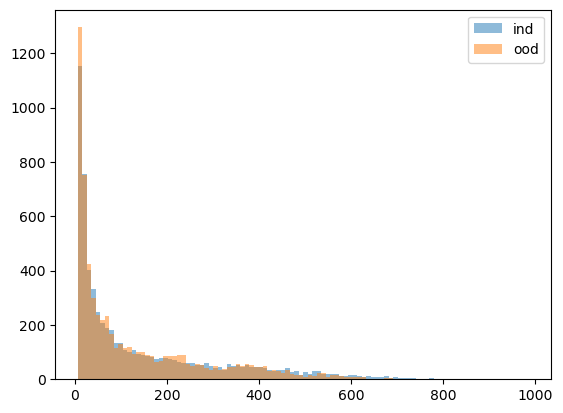

In [179]:
bins = plt.hist(loss_te,bins = 100,alpha = 0.5,label="ind")
plt.hist( loss_ood,bins = bins[1],alpha = 0.5,label = "ood")
plt.legend()

As well as the unconditional likelihood

In [180]:
loss_diff, loss_klz = vdm.apply(store.params, ims, 0 * lbs, rngs={"sample": rng})
losses = jax.tree_map(lambda x: np.mean(x) / (onp.prod(ims.shape[1:]) * np.log(2)), {"loss_diff": loss_diff, "loss_klz": loss_klz})
print(losses, "\n", sum(losses.values()))

128


ValueError: Input type must be an integer or unsigned integer.

We can also generate images from the model

In [75]:
def viewer(x, **kwargs):
  # x = np.clip((x + 1)/2.0, 0, 1)
  return rawarrview(reshape_image_batch(x), **kwargs)

Here we'll demonstrate unconditional generations from the model, as well as class conditional generations.  Finally we'll also showcase some guided generations which use [classifier free guidance](https://arxiv.org/abs/2207.12598) to clean up the samples.

In [ ]:
conditioning = np.arange(128) % 101
gen_dist = generate(vdm, store.params, rng, (128,), conditioning)
gen = gen_dist.mean()
ugen_dist = generate(vdm, store.params, rng, (128,), 0 *conditioning)
ugen = ugen_dist.mean()
cgen_dist = generate(vdm, store.params, rng, (128,), conditioning, guidance_weight=1.0)
cgen = cgen_dist.mean()


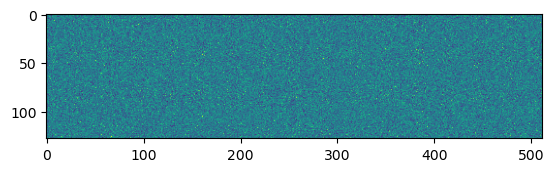

In [88]:
plt.imshow(gen_dist)

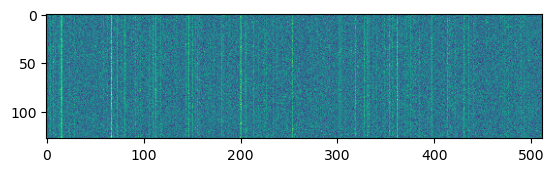

In [89]:
plt.imshow(ugen_dist)

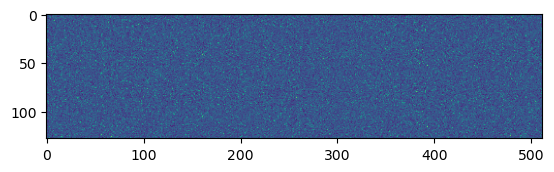

In [90]:
plt.imshow(cgen_dist)

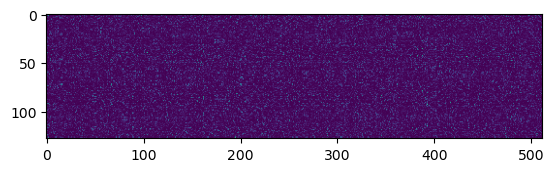

In [91]:
plt.imshow(next(batches)[0])

We can view the impact of the guidance weight on the quality of the samples. Below each row corresponds to samples with a different guidance weight. A guidance weight of -1 is unconditional samples, 0 is conditional samples, and values > 0 are increasing classifier-free guidance.

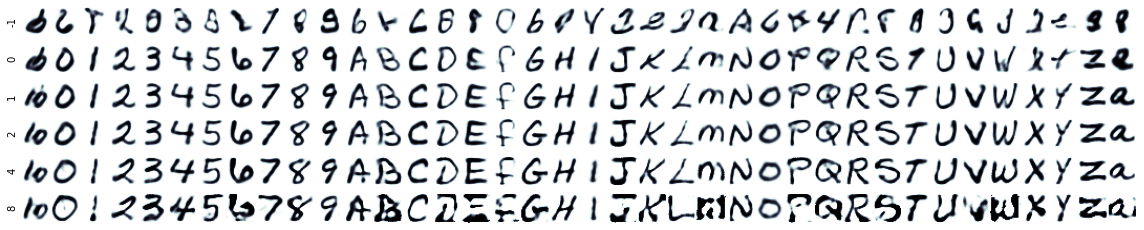

In [ ]:
samples = []
gws = (-1., 0., 1., 2., 4., 8.)
for guidance_weight in gws:
  cgen_dist = generate(vdm, unreplicate(pstore).params, rng, (128,),
                       conditioning, guidance_weight=guidance_weight)
  samples.append(cgen_dist.mean().squeeze(-1))

n = len(gws)
plt.figure(figsize=(20,4))
for i, (gw, imgs) in enumerate(zip(gws, samples)):
  plt.subplot(n, 1, i + 1)
  plt.imshow(reshape_image_batch(imgs, rows=1, cut=28 + 10), cmap='bone_r')
  plt.xticks([])
  plt.yticks([])
  plt.box(False)
  plt.ylabel('%.f'%gw)

Since our model is a conditional generative model, another thing we can do is use it as a classifier.  Here we'll evaluate its performance on a single test batch.

In [ ]:
conditioning = np.zeros(512).astype('int')
rng, spl = jax.random.split(rng)
elbos = jax.jit(lambda pk: elbo(vdm, unreplicate(pstore).params, spl, ims, (np.zeros(ims.shape[0]) + pk).astype('int')))
cond_elbos = jax.lax.map(elbos, np.arange(26 + 26 + 10 + 1))
(jax.nn.softmax(-cond_elbos.at[0].set(np.inf), axis=0).argmax(0) == lbs).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  This is separate from the ipykernel package so we can avoid doing imports until


DeviceArray(0.7421875, dtype=float32)

Next we'll look at some "reconstructions" in our diffusion model where we encode some images to some finite depth in our model and then run the generative process on the way back.

In [ ]:
T = 0.8
recon_dist = recon(vdm, unreplicate(pstore).params, rng,
                   np.array([T]), ims, lbs)
rec = recon_dist.mean()
urecon_dist = recon(vdm, unreplicate(pstore).params, rng,
                   np.array([T]), ims, 0 * lbs)
urec = urecon_dist.mean()

viewer(ims.squeeze(-1), cmap='bone_r')
print("RECON")
viewer(rec.squeeze(-1), cmap='bone_r')
print("UNCOND RECON")
viewer(urec.squeeze(-1), cmap='bone_r')

Our diffusion model was a latent diffusion model, so it had its own encoder and decoder as part of the model, here we'll look at the reconstructions in that model, i.e. we'll do a diffusion style reconstruction but at t=0.

In [ ]:
recon_dist = vdm.apply(unreplicate(pstore).params, ims, lbs, method=vdm.shortcut, rngs={"sample": rng})
rec = recon_dist.mean()
urecon_dist = vdm.apply(unreplicate(pstore).params, ims, 0 * lbs, method=vdm.shortcut, rngs={"sample": rng})
urec = urecon_dist.mean()

viewer(ims.squeeze(-1), cmap='bone_r')
print("SHORTCUT")
viewer(rec.squeeze(-1), cmap='bone_r')
print("UNCOND SHORTCUT")
viewer(urec.squeeze(-1), cmap='bone_r')